In [1]:
import os
import sys
from datetime import datetime
import keras
import random
import argparse
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, SGD, Adamax

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import utils as myutils
from model import build_model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/katieyth/gynecology/utils.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance(

In [2]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-d' ,'--data_dir', type=str, default='/home/katieyth/gynecology/data/', help='data directory')
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='management', help='prediction target')
# variability	UA	 deceleration management

# input parameter
parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
parser.add_argument('-ks','--k_slice', type=int, default=1, help='a input will be sliced into k_slice segments when testing')
parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')
parser.add_argument('-fb' ,'--force_binary', type=int, default=1, help='force to binary task')
parser.add_argument('-sb' ,'--split_by_patient', type=int, default=1, help='split by patient')

# data augmentation 
parser.add_argument('-aug_fliplr' ,'--aug_fliplr', type=int, default=1, help='reverse time series')
parser.add_argument('-shift' ,'--DA_Shift', type=int, default=0, help='')
parser.add_argument('-scale' ,'--DA_Scale', type=int, default=0, help='')
parser.add_argument('-randsamp' ,'--DA_RandSampling', type=int, default=0, help='')


# model parameters
parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
parser.add_argument('-ly' ,'--layers', type=int, default=10, help='number of residual layers')
parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
parser.add_argument('-l2','--l2', type=float, default=0.1, help='coefficient of l2 regularization')

# hyper-parameters
parser.add_argument('-lr','--learning_rate', type=float, default=1e-3, help='learning_rate')
parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=5, help='reduce_lr_patience')
parser.add_argument('-bs','--batch_size', type=int, default=16, help='batch_size')
parser.add_argument('-ep','--epoch', type=int, default=1000, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=1, help='whether weight balancing or not')
parser.add_argument('-mntr','--monitor', type=str, default='val_acc', help='val_acc or val_loss')


parser.add_argument('-g' ,'--gpu_id', type=str, default='6', help='GPU ID')
parser.add_argument('-rs' ,'--random_state', type=int, default=13, help='random state when train_test_split')
parser.add_argument('-fn' ,'--summary_file', type=str, default=None, help='summary filename')


FLAG = parser.parse_args([])
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id
#train(FLAG)

In [3]:
# %load utils.py
import os
import keras
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

MEAN_B, STD_B = 138.712, 16.100
MEAN_M, STD_M =  36.346, 25.224

def Probability(a):
    def prob():
        return random.uniform(a=0, b=1) > a
    return prob

def DA_RandomNoise(x):
    noise = np.array([[random.gauss(mu=0, sigma=0.01), 
                       random.gauss(mu=0, sigma=0.01)] for _ in range(x.shape[0])], dtype=np.float32)
    return x + noise

def DA_Shift(x, smin=-5, smax=5):
    shift = np.around(random.uniform(a=smin, b=smax))
    return x + shift

def DA_Scale(x, smin=0.8, smax=1.2):
    scale = random.uniform(a=smin, b=smax)
    return np.round(x*scale)

def DA_TimeWarp(X, sigma=0.2):
    length = X.shape[0]
    channel = X.shape[1]
    knot = 4
    
    from scipy.interpolate import CubicSpline      # for warping

    xx = (np.ones((channel,1))*(np.arange(0, length, (length-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, channel))
    x_range = np.arange(length)
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    tt = np.array([cs_x(x_range)]).transpose()

    tt_new = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(length-1)/tt_new[-1,0]]
    tt_new[:,0] = tt_new[:,0]*t_scale[0]

    # tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(length)
    
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,0], X[:,1])
    return X_new

def data_preprocess(x,  normalized, random_noise, aug_func=[], prob=0.5):
    do_or_not = Probability(prob)
    
    length = x.shape[0]
    # get x and then remove zeros (no info)
    x = x[(x[:,0] > 0.0) * (x[:,1] > 0.0)]
    
    # add random_noise
    if aug_func:
        for func in aug_func:
            if do_or_not():
                x = func(x)
    
    if normalized:
        x[:,0] = (x[:,0] - MEAN_B)/STD_B
        x[:,1] = (x[:,1] - MEAN_M)/STD_M

    
    if random_noise:
        x1, x2 = np.mean(x, axis=0)
        noise = np.array([[random.gauss(mu=0, sigma=0.01), 
                           random.gauss(mu=0, sigma=0.01)] for _ in range(x.shape[0])], dtype=np.float32)
        x = x + noise

    # transpose to (n_channel, arbitrary length), then padd to (n_channel, length)
    x = pad_sequences(np.transpose(x), padding='post', value=0.0, maxlen=length, dtype=np.float)

    # transpose back to original shape and store
    return np.transpose(x)


def k_slice_X(Xvalid, Yvalid, k_slice=5, length=300, class_weight = {}):
    """
    # moving across a sequence, we slice out "k_slice" segments with a constant interval
    # in order to increase validation data
    # ex:  |------------------|
    # 1    |------|
    # 2       |------|
    # 3          |------|
    # 4             |------|
    # 5                |------|
    """
    if not class_weight:
        class_weight = dict()
        for i in range(Yvalid.shape[1]):
            class_weight[i] = 1

    intvl = (Xvalid.shape[1] - length)//k_slice

    Xtest = np.empty((Xvalid.shape[0]*k_slice, length, Xvalid.shape[2]))
    Ytest = np.empty((Yvalid.shape[0]*k_slice, Yvalid.shape[1]))
    Wtest = np.empty((Yvalid.shape[0]*k_slice,))

    for k in range(k_slice):
        st = k * Xvalid.shape[0]
        for i in range(Xvalid.shape[0]):
            # print(st+i)
            Xtest[st+i,:,:] = data_preprocess(Xvalid[i,k*intvl:(k*intvl+length),:])
            Ytest[st+i,:] = Yvalid[i,:]
            Wtest[st+i] = class_weight[np.argmax(Yvalid[i,:])]
    return Xtest, Ytest, Wtest

def get_n_zeros(d):
    n_zeros = list()
    for i in range(d.shape[0]):
        n_zeros.append(sum(d[i,:] ==0))
    return np.array(n_zeros)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_keras_csv_logger(csv_logger, save_dir='', accuracy=False):
    loss = pd.read_table(csv_logger.filename, delimiter=',')
    print('min val_loss {0} at epoch {1}'.format(min(loss.val_loss), np.argmin(loss.val_loss)))
    plt.plot(loss.epoch, loss.loss, label='loss')
    plt.plot(loss.epoch, loss.val_loss, label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.close()

    if accuracy:
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_acc), np.argmax(loss.val_acc)))
        plt.plot(loss.epoch, loss.acc, label='accu')
        plt.plot(loss.epoch, loss.val_acc, label='val_accu')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'accu.png'))
        plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/z

In [4]:
print("===== create directory =====")
model_id = FLAG.target + "_" + datetime.now().strftime("%y%m%d%H%M%S_COMBINE")
model_save = os.path.join(FLAG.model_save, FLAG.target, model_id)
summary_save = os.path.join(FLAG.model_save, FLAG.target, 'summary_'+FLAG.target+'.csv')

if not os.path.exists(model_save):
    os.makedirs(model_save)
    print(model_save)
    
# if not os.path.exists(model_save):
#     os.mkdir(model_save)
#     print('directory {0} is created.'.format(model_save))
# else:
#     print('directory {0} already exists.'.format(model_save))

===== create directory =====
/home/katieyth/gynecology/model_save/management/management_181024134105_COMBINE


In [5]:
print("===== train =====")
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id

d = pd.read_csv(os.path.join(FLAG.data_dir, 'data_merged.csv'))
d = d[myutils.get_n_zeros(np.array(d[[k for k in d.columns if 'b-' in k]], dtype=np.float)) <= FLAG.acceptable_zeros_threshold]

if FLAG.force_binary : 
    d[d[FLAG.target]>1] = 1

n_classes = len(set(d[FLAG.target]))

# replace 0 (no readings) with np.nan for later substitution
for k in d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        d.loc[d[k]==0, k] = np.nan

# train test split

if FLAG.split_by_patient:
    train_id, valid_id = train_test_split(list(set(d.ID)), test_size=0.3, random_state=FLAG.random_state)
    train_d, valid_d = d[[k in set(train_id) for k in d.ID]], d[[k in set(valid_id) for k in d.ID]]
else:
    train_d,valid_d = train_test_split(d, test_size=0.3, random_state=FLAG.random_state, stratify =d[FLAG.target])

# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
Ytrain = keras.utils.to_categorical(np.array(train_d[FLAG.target]), num_classes=n_classes)
Yvalid = keras.utils.to_categorical(np.array(valid_d[FLAG.target]), num_classes=n_classes)

# weight balancing or not
if FLAG.weight_balance:

    y_integers = np.argmax(Ytrain, axis=1)
    d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    class_weight = dict(enumerate(d_class_weight))
    print('class weight: {0}'.format(class_weight))
else:
    class_weight = dict()
    for i in range(n_classes):
        class_weight[i] = 1

# k fold of validation set
Xtest, Ytest, Wtest = myutils.k_slice_X(Xvalid, Yvalid, length=FLAG.length, k_slice=FLAG.k_slice, class_weight = class_weight)

===== train =====
class weight: {0: 0.7959183673469388, 1: 1.3448275862068966}


In [6]:
Xtrain.shape

(156, 600, 2)

In [7]:
Xvalid.shape

(50, 600, 2)

In [8]:
model_mngmnt = "/home/katieyth/gynecology/model_save/management/management_181024103243/" # 0.8548
#model_mngmnt = "/home/katieyth/gynecology/model_save/management/management_181023142315/"

model_ua = "/home/katieyth/gynecology/model_save/UA/UA_181023202833" # 0.9839
model_var = "/home/katieyth/gynecology/model_save/variability/variability_181024061504/" # 0.9032
model_dec = "/home/katieyth/gynecology/model_save/deceleration/deceleration_181024061151" # 0.8226

In [9]:
# evaluate validation set
trained_model = load_model(os.path.join(model_mngmnt,'model.h5'))
Pred = trained_model.predict(Xtest)

Confusion matrix, without normalization
[[30  4  1]
 [ 3 12  0]
 [ 0  0  0]]
Confusion matrix, without normalization
[[30  4  1]
 [ 3 12  0]
 [ 0  0  0]]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


0-segment accuracy=0.84
avg accu=0.84
vote accu=0.84


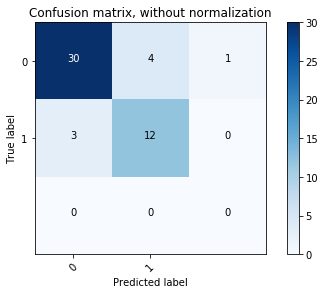

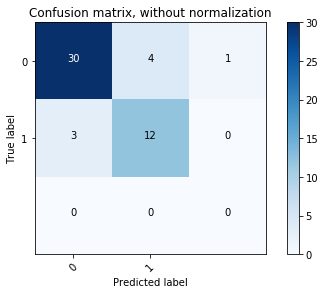

In [10]:
# evaluate by every segment
ypred_aug = np.argmax(Pred , axis=1)
ytest_aug = np.argmax(Ytest, axis=1)

cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)

plt.figure()
myutils.plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='Confusion matrix, without normalization')
# aggregate by voting
ypred = np.round(np.mean(ypred_aug.reshape(FLAG.k_slice,-1), axis=0), 0)
#ypred = (np.mean(ypred_aug.reshape(FLAG.k_slice,-1), axis=0) > 0.5) + 0 # voting
ytest = np.argmax(Yvalid, axis=1)

# calculate aggregated results
cfm = confusion_matrix(y_pred=ypred, y_true=ytest)
recall = np.diag(cfm) / np.sum(cfm, axis=1)
precision = np.diag(cfm) / np.sum(cfm, axis=0)
vote_val_accu = accuracy_score(y_pred=ypred, y_true=ytest)

plt.figure()
myutils.plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='Confusion matrix, without normalization')
# calculate average accuracy from segments
# and voting accuracy
tmp = ypred_aug.reshape(FLAG.k_slice,-1)
savg_val_accu = 0.0
for i in range(tmp.shape[0]):
    accu = accuracy_score(y_pred=tmp[i,:], y_true=ytest)
    print('{0}-segment accuracy={1}'.format(i, accu))
    savg_val_accu += accu
savg_val_accu /= tmp.shape[0]
print('avg accu={0}'.format(savg_val_accu))
print('vote accu={0}'.format(vote_val_accu))

In [11]:
features = trained_model.get_layer('global_average_pooling1d_1')
extractor = Model(inputs=trained_model.input, outputs=features.output)

In [12]:
n_valid_batch = np.ceil(len(Xtest)/FLAG.batch_size).astype(int)

In [13]:
valid_feature_list = list()
for i in range(n_valid_batch):
    print("validation batch {0}/{1}".format(i+1, n_valid_batch), end='\r')
    valid_feature_list.append(extractor.predict(x=Xtest))

Fvalid = np.vstack(valid_feature_list)
Fvalid = Fvalid[:len(Xtest),:]

In [14]:
##### get predcition
trained_model = load_model(os.path.join(model_var,'model.h5'))
Pred_var = trained_model.predict(Xtest)

##### get predcition
trained_model = load_model(os.path.join(model_ua,'model.h5'))
Pred_ua = trained_model.predict(Xtest)

##### get predcition
trained_model = load_model(os.path.join(model_dec,'model.h5'))
Pred_dec = trained_model.predict(Xtest)


In [15]:
col = ['feature'+'_'+ str(j) for j in  range(Fvalid.shape[1])]
col_var = ['var'+'_'+ str(j) for j in  range(Pred_var.shape[1])]
col_ua = ['ua'+'_'+ str(j) for j in  range(Pred_ua.shape[1])]
col_dec = ['dec'+'_'+ str(j) for j in  range(Pred_dec.shape[1])]

In [16]:
df_feature = pd.DataFrame(Fvalid)
df_var = pd.DataFrame(Pred_var)
df_ua = pd.DataFrame(Pred_ua)
df_dec = pd.DataFrame(Pred_dec)

In [17]:
df_feature.columns = col
df_var.columns = col_var
df_ua.columns = col_ua
df_dec.columns = col_dec

# test_data : predict with doctor label

In [18]:
test_size = 0.1
valid_d.reset_index(drop=True, inplace=True)

In [19]:
one_hot_column = ['variability', 'UA', 'deceleration']
numeric_column = ['FHB', 'UA_duration', 'UA_interval', 'seconds']
one_hot_df = pd.DataFrame()
for tg in one_hot_column:
    tmp_dm = pd.get_dummies(valid_d[tg])
    tmp_dm.columns = [tg+'_'+str(i) for i in range(tmp_dm.shape[1])]
    one_hot_df = pd.concat([one_hot_df, tmp_dm], axis=1)

In [20]:
numeric_column = ['FHB','UA_duration', 'UA_interval', 'seconds']

In [21]:
import xgboost as xgb
from xgboost import plot_importance 
from matplotlib import pyplot
def XGB():
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=13, stratify = Y)
    eval_set = [(X_train, Y_train), (X_test, Y_test)]
    xgb_clsfy = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
    xgb_clsfy.fit(X_train, Y_train, eval_metric=["error", "logloss"],
                  eval_set=eval_set, verbose=False)

    preds = xgb_clsfy.predict(X_test)
    cfm = confusion_matrix(y_pred=preds, y_true=Y_test)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=preds, y_true=Y_test)

    myutils.plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='Confusion matrix, without normalization')
    print(cfm)
    for i in range(n_classes):
        print('recall-{0} : {1}'.format(i, recall[i]))
        #sav['precision-{0}'.format(i)] = precision[i]
    print('accu={0}'.format(val_accu))

    plot_importance(xgb_clsfy)
    pyplot.show()
    results = xgb_clsfy.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()

Confusion matrix, without normalization
[[3 1]
 [0 1]]
[[3 1]
 [0 1]]
recall-0 : 0.75
recall-1 : 1.0
accu=0.8


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


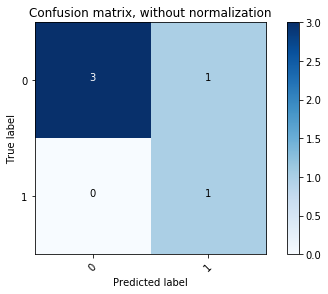

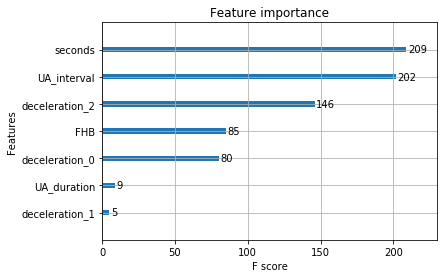

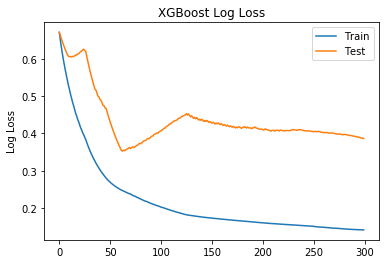

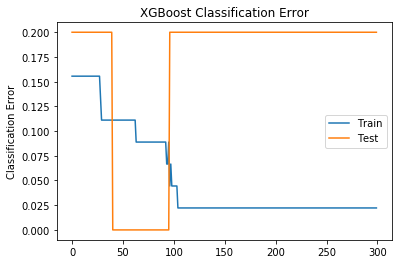

In [22]:
X = pd.concat([one_hot_df, valid_d.loc[:,numeric_column]], axis=1)
Y = valid_d.loc[:, 'management']
n_classes = len(set(Y))
XGB()

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[3 1]
 [0 1]]
[[3 1]
 [0 1]]
recall-0 : 0.75
recall-1 : 1.0
accu=0.8


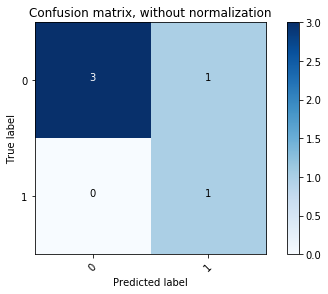

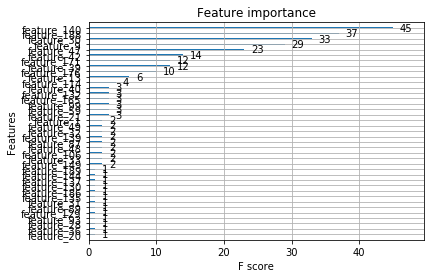

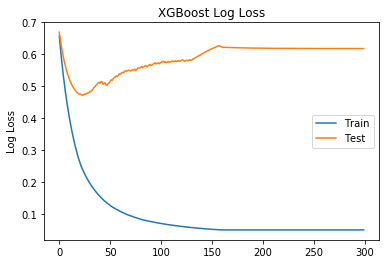

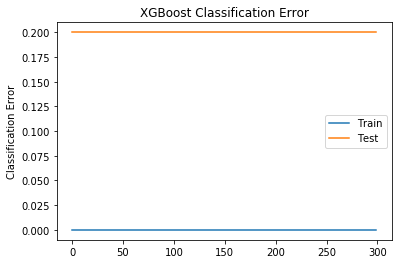

In [23]:
X = pd.concat([df_feature, df_var, df_ua, df_dec], axis=1)
X = pd.concat([X, valid_d.loc[:,numeric_column]], axis=1) 
Y = valid_d['management']
XGB()

Confusion matrix, without normalization
[[1 3]
 [0 1]]
[[1 3]
 [0 1]]
recall-0 : 0.25
recall-1 : 1.0
accu=0.4


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


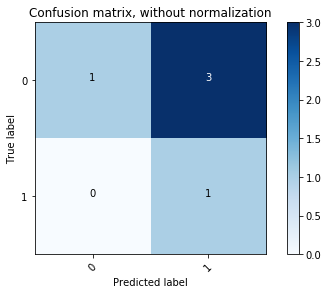

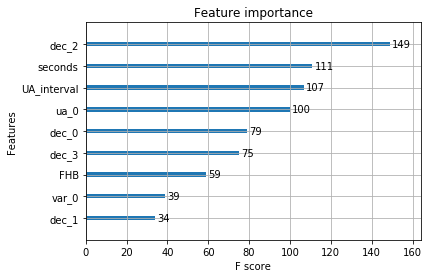

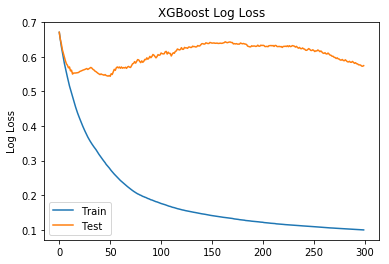

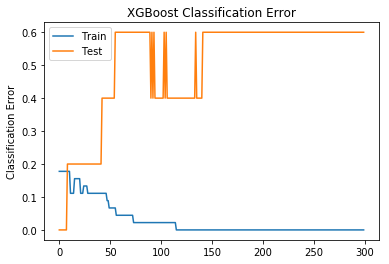

In [24]:
X = pd.concat([df_var, df_ua, df_dec], axis=1)
X = pd.concat([X, valid_d.loc[:,numeric_column]], axis=1)
Y = valid_d['management']
XGB()